# Load the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [3]:
data_train_raw.shape

(188318, 132)

# Data transformation

In [4]:
ylog=np.log1p(data_train_raw['loss'])
# ymean=ylog.mean()
# ystd=ylog.std()
ymean=ylog.min()
ystd=ylog.max()
data_train_raw['loss_g']=(ylog-ymean)/ystd

In [5]:
# clean outliers in training data
lossMean = data_train_raw['loss_g'].mean()
lossStd = data_train_raw['loss_g'].std()
print('Mean of log1py: {}'.format(lossMean))
print('Std of log1py: {}'.format(lossStd))
lbound = lossMean-3.0*lossStd
ubound = lossMean+3.0*lossStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw['loss_g']>=lbound) & (data_train_raw['loss_g']<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))

Mean of log1py: 0.612892612558
Std of log1py: 0.0693210249117
Lower clipping bound: 0.404929537823
Upper clipping bound: 0.820855687293
Shape of cleaned data: (187954, 133)


In [6]:
def ToUniform(y):
    z = norm.cdf(-y/np.sqrt(2))
    return z
def UniformToGauss(z):
    return -np.sqrt(2)*norm.ppf(z)*ystd+ymean
# def BackToOriginal(z):
#     return np.exp(UniformToGauss(z))

data_train_raw['loss_u']=ToUniform(data_train_raw['loss_g'])

def lossRestore(logloss, ymean, ystd):
    loss = np.expm1(logloss*ystd+ymean)
    return loss

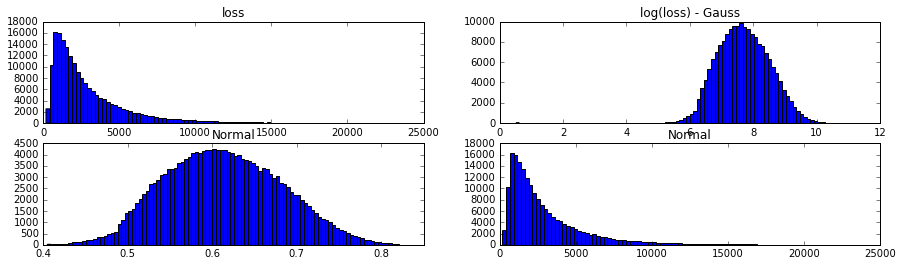

In [7]:
plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
plt.hist(data_train_raw['loss'],100)
plt.title('loss');

plt.subplot(2,2,2)
plt.hist(ylog,100)
plt.title('log(loss) - Gauss');

plt.subplot(2,2,3)
plt.hist(data_train_raw['loss_g'],100)
plt.title('Normal');

plt.subplot(2,2,4)
plt.hist(lossRestore(data_train_raw['loss_g'],ymean,ystd),100)
plt.title('Normal');

# Data preparation - labeling encoder

In [8]:
# save label in a seperate serie
labelSs = data_train_raw['loss_g'] 
trainDf = data_train_raw.drop(['id','loss','loss_g','loss_u'],axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has features from the raw data:\n{}'.format(trainDf.columns))
print('testDf has features from the raw data:\n{}'.format(testDf.columns))

trainDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [9]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313500, 130)
(313500, 116) of which are categorical
(313500, 14) of which are continuous


In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in dataCatAll.columns:
    if (col.find('cat') !=-1):
#        print(col)
        dataCatAll[col]=le.fit_transform(dataCatAll[col])
#         dataAll[col] = dataAll[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
#         le.classes_ = np.append(le.classes_, '<unknown>')
#         data_test_raw[str(col+'_numerical')]=le.transform(data_test_raw[col])
print(dataCatAll.columns)


/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cat107', u'cat108', u'cat109', u'cat110', u'cat111', u'cat112',
       u'cat113', u'cat114', u'cat115', u'cat116'],
      dtype='object', length=116)


# restore to x_trainDf and x_testDf - skipped

In [11]:
# # hstack all the features and .
# x_allDf = pd.concat([dataCatAll,dataFltAll],axis=1)
# x_means = x_allDf.mean()
# x_stds = x_allDf.std()
# x_allDf = (x_allDf-x_means)/x_stds
# x_allDf.head()

In [12]:
# x_Train = x_allDf.iloc[0:len(labelSs),:]
# x_Test = x_allDf.iloc[len(labelSs):,:]
# y_Train = labelSs

# one-hot-encoding

In [13]:
# one-hot-encoding the categorical features
enc = preprocessing.OneHotEncoder()
x_catAll = enc.fit_transform(dataCatAll)
print(x_catAll.shape)

(313500, 1175)


In [14]:
# split x_train and x_test
x_Train = sp.sparse.hstack((x_catAll[0:len(labelSs),:], sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_Test = sp.sparse.hstack((x_catAll[len(labelSs):,:], sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_Train = labelSs.values

# check the dimension of prepared data

In [15]:
print(x_Test.shape)
print(x_Train.shape)
print(y_Train.shape)

(125546, 1189)
(187954, 1189)
(187954,)


# splite the training data for valication

In [16]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_Train, y_Train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(150363, 1189)
(150363,)
(37591, 1189)
(37591,)


In [17]:
del x_Train
del y_Train
del x_catAll
del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [18]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [19]:
testList = ['XGBoostTrees', 'AdaBoosting', 'MLPRegressor','Ensemble']

### Ridge Regression

In [20]:
# from sklearn.linear_model import RidgeCV
# # from sklearn.linear_model import Ridge

In [21]:
# cv = 3
# # alphas = (1e-2,1e-1,1,1e1,1e2)
# # alphas = (20,30,40)
# alphas = [40]
# regCV = RidgeCV(cv=cv,alphas = alphas)
# regCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(regCV.alpha_))
# # print('cv_values_: {}\n'.format(regCV.cv_values_))

In [22]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV.predict(x_val),ymean,ystd)))

In [23]:
# y_pred_i = lossRestore(regCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(regCV.predict(x_val),ymean,ystd))

### Lasso Regression

In [24]:
# from sklearn.linear_model import LassoCV

In [25]:
# cv = 3
# # alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3)
# # alphas = (0.0005,0.0007,0.001,0.003,0.005)
# # alphas = [0.00005,0.0001,0.0003,0.0005]
# alphas = [0.00005]
# LassoCV = LassoCV(cv=cv,alphas = alphas)
# LassoCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(LassoCV.alpha_))

In [26]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(LassoCV.predict(x_val),ymean,ystd)))

In [27]:
# y_pred_i = lossRestore(LassoCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(LassoCV.predict(x_val),ymean,ystd))

### Skipped - Random Forest - using mse rather than mae, because the mae implementation is much slower.

In [28]:
# from sklearn.ensemble import RandomForestRegressor

In [29]:
# criterion = 'mse'
# n_estimators = [30]
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpRFReg = RandomForestRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
#     tmpRFReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpRFReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         RFReg = tmpRFReg
#         n_estimator = n_est
#         err = err_i

In [30]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(RFReg.predict(x_val),ymean,ystd)))

In [31]:
# y_pred_i = lossRestore(RFReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(RFReg.predict(x_val),ymean,ystd))

### XGBoost Trees

In [32]:
import xgboost as xgb

In [33]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_Test.tocsc())

In [45]:
num_round = 1000
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':1,'eta':0.155,'min_child_weight':1}# 1134, 200 rounds
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':1,'eta':0.15,'min_child_weight':1}# 1133, 250 rounds
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0,'eta':0.1,'min_child_weight':1}# 1128, 600 rounds
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0,'eta':0.05,'min_child_weight':0}# 1127, 1000

watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist)

[0]	eval-mae:0.109682	train-mae:0.109271
[1]	eval-mae:0.104732	train-mae:0.104322
[2]	eval-mae:0.100101	train-mae:0.099692
[3]	eval-mae:0.09577	train-mae:0.095361
[4]	eval-mae:0.091725	train-mae:0.091313
[5]	eval-mae:0.087956	train-mae:0.087539
[6]	eval-mae:0.084438	train-mae:0.084023
[7]	eval-mae:0.081155	train-mae:0.080742
[8]	eval-mae:0.078089	train-mae:0.077678
[9]	eval-mae:0.075254	train-mae:0.074847
[10]	eval-mae:0.072599	train-mae:0.072191
[11]	eval-mae:0.070113	train-mae:0.069702
[12]	eval-mae:0.067834	train-mae:0.067427
[13]	eval-mae:0.065695	train-mae:0.065286
[14]	eval-mae:0.063693	train-mae:0.063289
[15]	eval-mae:0.06183	train-mae:0.06143
[16]	eval-mae:0.060126	train-mae:0.059732
[17]	eval-mae:0.058564	train-mae:0.058166
[18]	eval-mae:0.05706	train-mae:0.056663
[19]	eval-mae:0.055719	train-mae:0.055317
[20]	eval-mae:0.054422	train-mae:0.054026
[21]	eval-mae:0.05326	train-mae:0.052864
[22]	eval-mae:0.052156	train-mae:0.051762
[23]	eval-mae:0.051151	train-mae:0.050758
[24]	ev

In [46]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))

1127.45756915


In [47]:
y_pred_i = lossRestore(gbt.predict(d_test_xgb),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))

### AdaBoost Regression

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

In [ ]:
# n_estimators = [30, 60, 90, 120]
# n_estimators = [10,20,30,40]
n_estimators = [6]
base_estimator = Ridge(alpha = 40)
err = 999999999
n_estimator = 0
random_state = 0
for n_est in n_estimators:
    tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state,base_estimator = base_estimator)
#     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state)
    tmpAdReg.fit(x_train,y_train)
    err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpAdReg.predict(x_val),ymean,ystd))
    print(err_i)
    if err_i < err:
        AdReg = tmpAdReg
        n_estimator = n_est
        err = err_i

In [ ]:
print('n_estimator = {}'.format(n_estimator))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(AdReg.predict(x_val),ymean,ystd)))

In [ ]:
y_pred_i = lossRestore(AdReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(AdReg.predict(x_val),ymean,ystd))

### Skipped - K Nearest Neighbors

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# n_neighbors = [5, 10, 15]
# weights = 'distance'
# err = 999999999
# n_nns = 0
# # random_state = 0
# for n_nn in n_neighbors:
#     tmpKNReg = KNeighborsRegressor(n_neighbors = n_nn,weights = weights)
#     tmpKNReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpKNReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         KNReg = tmpKNReg
#         n_nns = n_nn
#         err = err_i

In [ ]:
# print('n_neighbors = {}'.format(n_nns))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(KNReg.predict(x_val),ymean,ystd)))

In [ ]:
# y_pred_i = lossRestore(KNReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(KNReg.predict(x_val),ymean,ystd))

### Linear SVR

In [ ]:
# from sklearn.svm import LinearSVR

In [ ]:
# # SVReg = svm.SVR(kernel = 'rbf')
# # SVReg.fit(x_train,y_train)
# SVReg = LinearSVR(C=0.5)
# SVReg.fit(x_train,y_train)

In [ ]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(SVReg.predict(x_val),ymean,ystd)))

In [ ]:
# y_pred_i = lossRestore(SVReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(SVReg.predict(x_val),ymean,ystd))

### MLP Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
MLPReg = MLPRegressor(alpha = 1e-5, hidden_layer_sizes = (35,3),random_state=0,early_stopping=True)
MLPReg.fit(x_train,y_train)

In [ ]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(MLPReg.predict(x_val),ymean,ystd)))

In [ ]:
y_pred_i = lossRestore(MLPReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(MLPReg.predict(x_val),ymean,ystd))

# save files for submission

In [ ]:
# ensemble the results
y_pred.append(np.ndarray.mean(np.vstack(y_pred).T,axis=1))

# ensembled y_val
print('The loss of the ensembled result:')
y_pred_val_en = np.ndarray.mean(np.vstack(y_pred_val).T,axis=1)
mean_absolute_error(lossRestore(y_val,ymean,ystd),y_pred_val_en)

In [ ]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [ ]:
from sklearn.externals import joblib
joblib.dump([regCV, gbt, AdReg, MLPReg, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_Test]
            ,'../output/models_data_on_raw_features.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

In [ ]:
testList
